# Components

In {term}`GDS` Factory, we create components and then connect them together to create larger, more complicated designs. Components can be simple shapes, or more complex with references to other components. They usually have ports which allow you to connect the component to other components in GDS Factory. 

## Elements of a Component

Components can be made up of polygons, references, and ports.

Polygons are the lowest building block of components, and if you print out a component's information, it will tell you how many polygons are contained within it. Since the same polygon is often used twice or multiple times within a component, it will often be referenced.

References to other components within a component, or circuit, are used to save memory as they point to an existing geometry instead of creating a new one. If, for example, you had a component that used the same taper on all of its inputs and outputs, it would be good to save it only once in memory and then call it and rotate it, if needed, however many times you need for the component instead of saving multiple copies of the same component. So, by using references you can draw on a bank of components to create more complex components without using up as much memory. 

Ports are placed at the inputs and outputs of components, although in a component with many pieces, you can place it at the interconnect between two components. You must specify the direction the port is facing (generally either into or out of the component). You can also specify the width of the port, although it is generally just the width of the input or output of the component it is attached to.

You can also add labels to your component to convey information not otherwise included. These labels will be seen in the gds file as well as in GDS Factory. A label is added to a component using the function ``add_label``, to which you pass what you want the label to say and where it should be in the component, as shown below:

``c.add_label(text="LABEL TEXT", position=c.center)``

## Creating Components

### How to Create a Component Using Polygons

In GDS Factory, polygons can be used to piece together a component's geometry. Polygons are defined with their vertices and the layer in which they are on. For components with more complex functions, i.e. not just passive components, more than one layer may be needed to define the component. In this case, you can specify what parts of your component are on which layer. As an example, let us create a 2x2 {term}`MMI` using polygons to define the tapers and the body of the MMI.

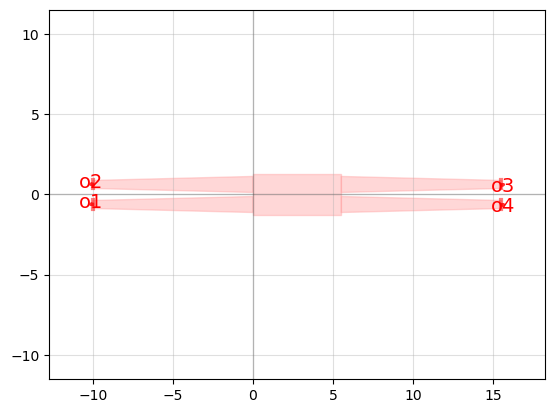

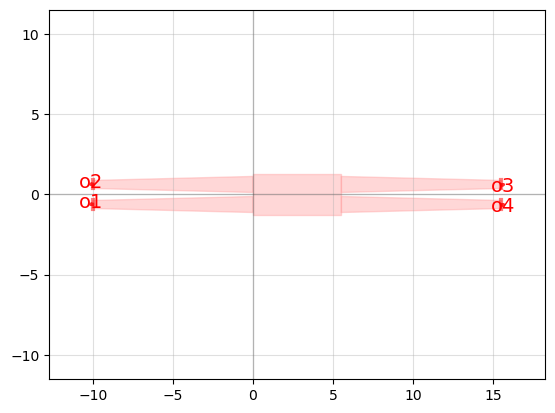

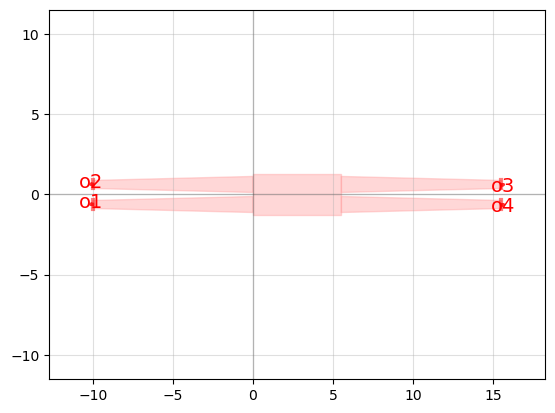

In [39]:
import gdsfactory as gf

# Create a component containing a polygon for the taper
# This will be referenced in the final component
taper = gf.Component()
t_length = 10
t_input = 0.5
t_output = 1
t_gap = 0.125
mmi_length = 5.5
mmi_width = 2.5

# Create taper component to be referenced
taper.add_polygon(points=[(0,-t_input/2),(0,t_input/2),(t_length,t_output/2),(t_length,-t_output/2)], layer=1)

# Create component for 2x2 MMI, then add the MMI body and reference the tapers in the component
mmi = gf.Component()
mmi.add_polygon(points=[(0,mmi_width/2),(0,-mmi_width/2),(mmi_length,-mmi_width/2),(mmi_length,mmi_width/2)], layer=1)
mmi.add_ref(taper, origin=(-(t_length),t_output/2+t_gap), rotation=0)
mmi.add_ref(taper, origin=(-(t_length),-(t_output/2+t_gap)), rotation=0)
mmi.add_ref(taper, origin=(t_length+mmi_length,t_output/2+t_gap), rotation=180)
mmi.add_ref(taper, origin=(t_length+mmi_length,-(t_output/2+t_gap)), rotation=180)

# Add ports to the component
port_width = 0.5
port_center = 0.625
ports = [gf.Port('o1', orientation=180, center=[-t_length,-port_center], width=port_width, layer=(1, 0), port_type="optical"),
         gf.Port('o2', orientation=180, center=[-t_length,port_center], width=port_width, layer=(1, 0), port_type="optical"),
         gf.Port('o3', orientation=0, center=[mmi_length+t_length,port_center], width=port_width, layer=(1, 0), port_type="optical"),
         gf.Port('o4', orientation=0, center=[mmi_length+t_length,-port_center], width=port_width, layer=(1, 0), port_type="optical")
]
mmi.add_ports(ports)

# Plot the final design
mmi.plot()

# Compare with the GDSFactory component for the 2x2 MMI
gf.components.mmi2x2().plot()

### How to Create a Component from a GDSII file

It is sometimes necessary (or useful) to import a gds file into GDS Factory. This can happen if you have created a geometry using some other software, such as Meep, and you would like to the use the geometry in GDS Factory. While GDS Factory has functions to convert the geometry, there are several other steps you need to take after this conversion to get a useful GDS Factory component. 

The purpose of this notebook is to demonstrate the steps needed to create a complete GDS Factory component from a gds file.
 
For this example, I'll be using a gds design of a splitter that was created in Meep. 

This is an picture of the gds we will convert to a component:
![Image of splitter file](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/compFromGdsTutorial1.png)

Here we go!

We'll just be using gdsfactory here, so we'll include that at the top, and also make a variable to hold the path to the gds file. In our case, that will be "splitter1x2"

In [1]:
import gdsfactory as gf

fname = "splitter1x2.gds" # The filename or path of the gds

Our first step is to get the geometry from the gds file and create a component with that geometry.

In [ ]:
# Create a component with the same name as our gds
c = gf.Component(name=fname[len(fname)-4]) 

# Add the geometry from the gds as a reference to our component
# The << is shorthand for c.add_ref()
splitter = c << gf.read.import_gds(fname)

# Show the component
c.plot() 

Now we have a geometry, but in order to use it in gdsfactory, we need ports. Since our original gds did not have any ports, we must add them now. 

In [ ]:
# bbox is the bounding box of the component. 
# It stores the lower left and the upper right corners of the component in a 2D array
box = c.bbox 

# Find the middle y value
yMid = (box[1,1] - box[0,1])/2 + box[0,1]

# Add ports. 
c.add_port("o1", center=(box[0,0],yMid), orientation=180, width=0.5, layer=(1,0)) # adds the input port with the name "o1" It must be oriented 180 so it points out of the component
c.add_port("o2", center=(box[1,0],box[1,1]-0.25), orientation=0, width=0.5, layer=(1,0)) # adds the upper output port with name "o2"
c.add_port("o3", center=(box[1,0],box[0,1]+0.25), orientation=0, width=0.5, layer=(1,0)) # adds the lower output port with name "o3"

c.plot()

And there you go! 

Now that your gds is a component in GDS Factory, you can use it in conjunction with other GDS Factory functions to create more complicated designs. For example, GDS Factory's cutback_splitter function can be used to create {term}`cutbacks` using this splitter. 

You can install `pip install gdsfactory[full]` for better visualization


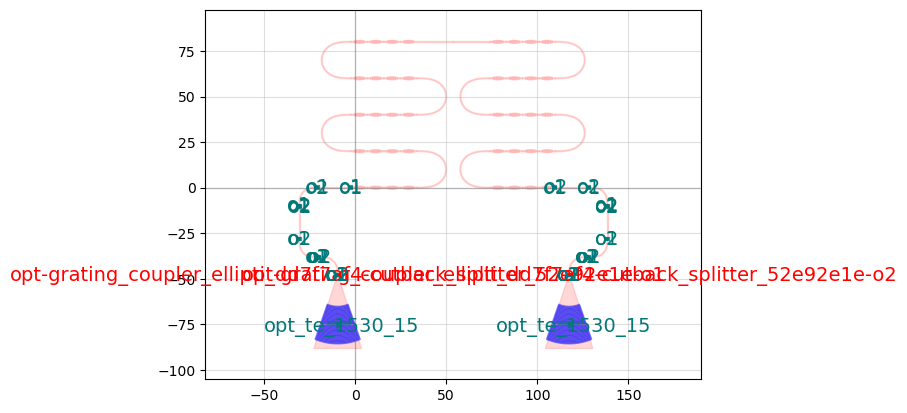

cutback_splitter_52e92e_42263575: uid ee21f529, ports ['opt-grating_coupler_ellipti_dd7f7af4-cutback_splitter_52e92e1e-o1', 'opt-grating_coupler_ellipti_dd7f7af4-cutback_splitter_52e92e1e-o2'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_5', 'bend_euler_6', 'straight_8', 'straight_9', 'straight_10', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'cutback_splitter_1'], 0 polygons


In [4]:
cutbacks = gf.components.cutback_splitter(component=c)
cutbacks = gf.routing.add_fiber_array(cutbacks, with_loopback = False)
cutbacks.plot()

### More Functions for Creating Components

GDS Factory comes with a variety of functions that can help you manipulate the geometry of your component, allowing you to more easily create many different shapes. For example, there are Boolean operators you can use to combine different geometries, meaning that you can subtract shapes from each other, merge them together, or XOR them. The accepted operations are "and", "not", "or", "xor", "A-B", "B-A", and "A+B". Of course, "A-B" is equivalent to "not" and "A+B" is equivalent to "or". To use these operations, you specify your two arguments (or pieces of the geometry that will be involved in the operation), the operation itself, and the layer:

```gf.geometry.boolean(A=[components],B=[components],operation="A-B",layer=1)```

### Connecting Components

Once you have created your components and perhaps tested them individually, you may want to connect them into a larger circuit with a more sophisticated function. To do this, you can use the "connect" function from GDS Factory.

This function takes in two ports as arguments. The first is the port in the component you are calling connect on that will attach to the second port, or the "destination" port.

As a simple example, we could use the following code to connect two waveguides to form a component:

2023-05-09 11:33:08.609 | INFO     | gdsfactory.config:<module>:50 - Load '/home/ebang4/miniconda3/envs/pmp/lib/python3.11/site-packages/gdsfactory' 6.27.0
2023-05-09 11:33:10.020 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/ebang4/miniconda3/envs/pmp/lib/python3.11/site-packages/gdsfactory/generic_tech/klayout/tech/layers.lyp.


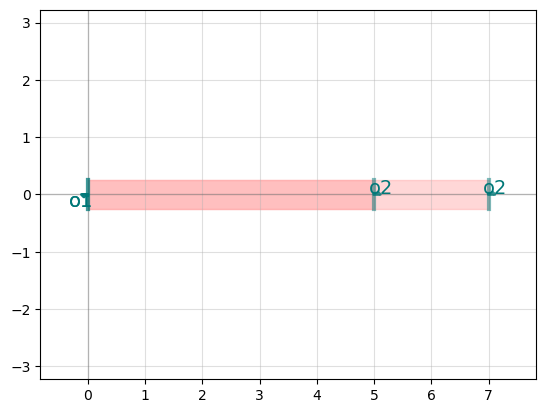

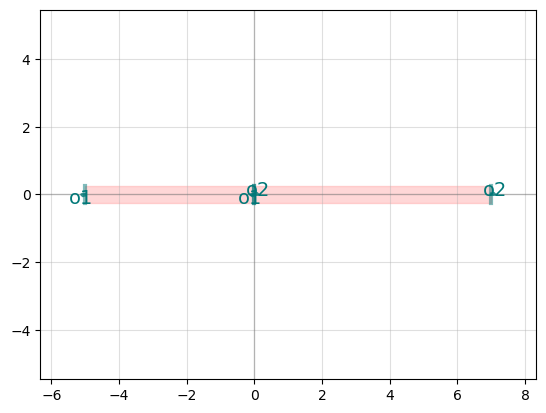

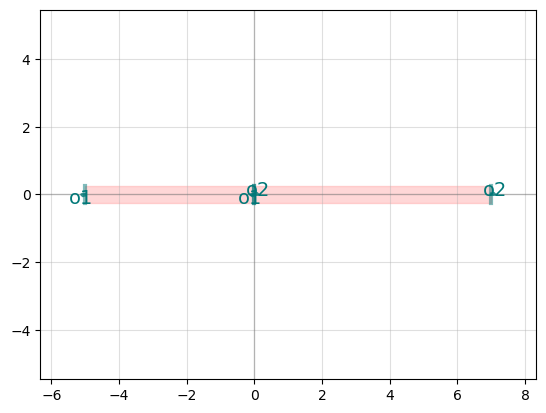

In [1]:
import gdsfactory as gf

# Create a component
c = gf.Component()

# Add references to two straight waveguides
wg_1 = c << gf.components.straight(length=5)
wg_2 = c << gf.components.straight(length=7)

# The contents of the component before connecting
c.plot()

# Connect the two waveguides and plot the final result
# To "o2" on wg_1, connect "o1" on wg_2
wg_1.connect("o2", destination=wg_2["o1"])
c.plot()

As your connections get more complex, be aware of the order in which you connect components. GDS Factory automatically moves components as they are connected, and they may be moved in ways you don't want. For example, the final geometry of the preceding example would be at different location if you used

```wg_2.connect("o1", destination=wg_1["o2"])```

Although the same two ports are being connected, the result differs because you are now connecting wg_1 to wg_2 and not wg_2 to wg_1. Essentially, take care when laying out the sequence of your connections.

### Connecting With an ASCII Sequence
If you have many connections that you need to make that only require a few components, you can connect components with an ASCII sequence.

To do this, you must create a dictionary to map ASCII symbols to components. Then you create a sequence to feed into ```gf.components.component_sequence```. For example, if we wanted to connect waveguides of different lengths in a repeating pattern you can print out the ports of a component if you aren't sure which is which. This will help you as you are making your connections. Also, it's good to double check your connections.



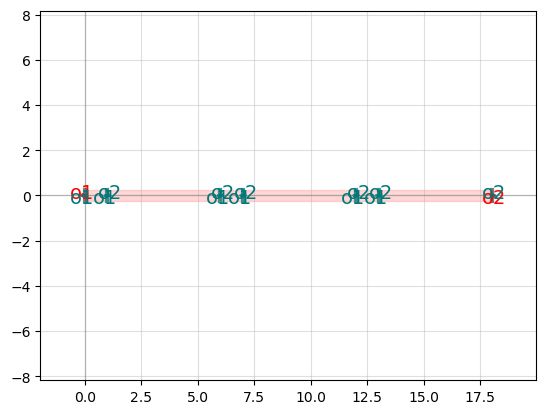

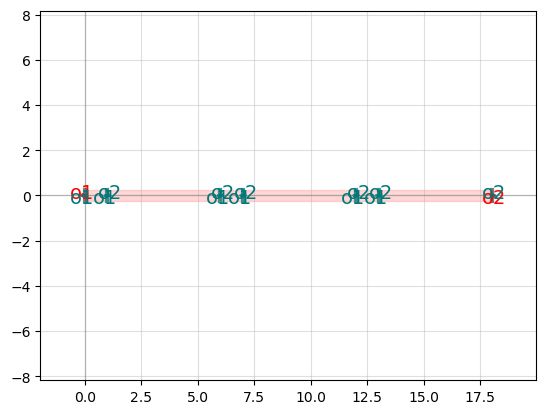

In [2]:
import gdsfactory as gf
short_wg = gf.components.straight(length=1)
long_wg = gf.components.straight(length=5)

symbol_to_component = {
    "S": (short_wg, "o1", "o2"),
    "L": (long_wg, "o1", "o2"),
}

sequence = "SLSLSL"
s = gf.components.component_sequence(sequence=sequence, symbol_to_component=symbol_to_component)
s.plot()

### Connecting Grating Couplers
Unless you plan on having an edge-coupled chip, you will most likely need {term}`grating couplers` to couple light into your circuit. So, the last component that you will want to connect to your circuit is grating couplers. ```add_grating_couplers``` automatically connects grating couplers to the ports in your component. Before using this function, you may want to make sure that your component/circuit has its ports specified. You don't have to, but it makes it easier to use this function. The function requires that you specify the component you are adding grating couplers to. If you have a component with many references in it, the function may try and add grating couplers to the ports of each reference, instead of just the main input and output ports. So, you either have to pass in arguments for the ```select_ports``` parameter, or just create new ports for the component. Going back to our example with the two straight waveguides, we can add ports to the ends of the now longer waveguide, absorb the references so that it truly appears as just one waveguide, and then add the grating couplers.

In [ ]:
# Add ports to the input and output
c.add_port("o1", port=wg_1.ports["o1"])
c.add_port("o2", port=wg_2.ports["o2"])

# Absorbe the references to the two waveguides
for i in range(len(c.references)-1, -1, -1):
    c.absorb(c.references[i])
    
# Add grating couplers
c = gf.components.add_grating_couplers(c)
c.plot()

### Practice:

* Pick a GDS Factory component and recreate it using polygons
* Use Boolean operators to create a cricular ring and then a racetrack ring.
* Create a directional coupler circuit using only GDS Factory default components